In [1]:
import sys
import importlib
# Make imports work
sys.path.insert(0, '../')

In [162]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from mhealth_anomaly_detection import simulate_daily
from mhealth_anomaly_detection import anomaly_detection
from mhealth_anomaly_detection import format_axis as fa

# Compare how anomalies are detected by different models in simulated anomalies 

## Simulate Data and run anomaly detectors

In [118]:
importlib.reload(simulate_daily)
# Dataset parameters
n_subjects = 50
days_of_data = 90
frequencies = [7, 14, 28]

n_features = 5
datasets = []

fname = f'exp01_nSubjects-{n_subjects}_nDays-{days_of_data}_n_features-{n_features}.csv'
fpath = Path('cache', fname)

for anomaly_frequency in frequencies:
    feature_param_dict = {
        'history_all_28': {
            f'history-{28}_anomalyFrequency-{anomaly_frequency}_{i}': {
                "min": 0,
                "max": 10,
                "mean": 5,
                "std": 2,
                "history_len": 28,
                "anomaly_frequency": anomaly_frequency,
                "anomaly_std_scale": 3
            } for i in range(n_features)
        },
        'history_0_to_28': {
            f'history-{feature_history}_anomalyFrequency-{anomaly_frequency}': {
                "min": 0,
                "max": 10,
                "mean": 5,
                "std": 2,
                "history_len": feature_history,
                "anomaly_frequency": anomaly_frequency,
                "anomaly_std_scale": 3
            } for feature_history in [0, 2, 7, 14, 28]
        },
    }
    for param_name, feature_params in feature_param_dict.items():
        # Simulate data according to params above
        simulator = simulate_daily.RandomAnomalySimulator(
            feature_params=feature_params,
            n_days=days_of_data,
            cache_simulation=False,
            n_subjects=n_subjects,
        )

        
        # Anomaly detector window (training) size
        window_sizes = [7, 14, 28]
        for window_size in window_sizes:
            # Simulate Data
            data = simulator.simulateData(use_cache=False)
            data['anomaly_freq'] = anomaly_frequency
            data['history_type'] = param_name
            data['window_size'] = window_size
            data['anomaly'] = (
                ((data['study_day'] % anomaly_frequency) == 0) &
                (data['study_day'] > 0)
            )

            # Run Anomaly Detection
            n_components = 3
            features = list(feature_params.keys())
            detectors = [
                anomaly_detection.BaseRollingAnomalyDetector(
                    features=features,
                    window_size=window_size,
                    max_missing_days=0,
                ),
                anomaly_detection.PCARollingAnomalyDetector(
                    features=features,
                    window_size=window_size,
                    max_missing_days=0,
                    n_components=n_components
                ),
                anomaly_detection.NMFRollingAnomalyDetector(
                    features=features,
                    window_size=window_size,
                    max_missing_days=0,
                    n_components=n_components
                ),
            ]
            for detector in detectors:
                data[f'{detector.name}_anomaly'] = np.nan
                for sid in tqdm(data.subject_id.unique(), desc=f'Running {detector.name} on each subject with {param_name}, ws: {window_size}, af: {anomaly_frequency}'):
                    subject_data = data.loc[data.subject_id == sid]
                    data.loc[data.subject_id == sid, f'{detector.name}_anomaly'] = detector.labelAnomaly(
                        detector.getReconstructionError(subject_data)
                    )
            datasets.append(data)
data_df = pd.concat(datasets)
data_df

Running RollingMean on each subject with history_all_28, ws: 7, af: 7: 100%|██████████| 50/50 [00:00<00:00, 213.16it/s]
Running PCA_3 on each subject with history_all_28, ws: 7, af: 7: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]
Running NMF_3 on each subject with history_all_28, ws: 7, af: 7:  12%|█▏        | 6/50 [00:06<00:46,  1.05s/it]/Users/akre96/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/onmf.py:256: RuntimeWarning: invalid value encountered in scalar divide
  dist = np.linalg.norm(H1 - H1_old, 2)/np.linalg.norm(H1_old, 2)
/Users/akre96/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/onmf.py:256: RuntimeWarning: invalid value encountered in scalar divide
  dist = np.linalg.norm(H1 - H1_old, 2)/np.linalg.norm(H1_old, 2)
Running NMF_3 on each subject with history_all_28, ws: 7, af: 7:  46%|████▌     | 23/50 [00:24<00:29,  1.08s/it]/Users/akre96/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/onmf

,subject_id,study_day,history-28_anomalyFrequency-7_0,history-28_anomalyFrequency-7_1,history-28_anomalyFrequency-7_2,history-28_anomalyFrequency-7_3,history-28_anomalyFrequency-7_4,ema_sad_choices,anomaly_freq,history_type,...,history-28_anomalyFrequency-28_0,history-28_anomalyFrequency-28_1,history-28_anomalyFrequency-28_2,history-28_anomalyFrequency-28_3,history-28_anomalyFrequency-28_4,history-0_anomalyFrequency-28,history-2_anomalyFrequency-28,history-7_anomalyFrequency-28,history-14_anomalyFrequency-28,history-28_anomalyFrequency-28
0,SID_0,0,10.0,2.580938,2.876037,7.394278,9.190743,2.0,7,history_all_28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SID_0,1,10.0,5.025828,0.126134,1.849093,9.198285,2.0,7,history_all_28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SID_0,2,10.0,5.442378,0.000000,5.760917,10.000000,2.0,7,history_all_28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SID_0,3,10.0,7.395656,0.000000,6.541104,10.000000,2.0,7,history_all_28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SID_0,4,10.0,8.108389,1.250463,5.236287,9.968636,2.0,7,history_all_28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,SID_49,85,NaN,NaN,NaN,NaN,NaN,2.0,28,history_0_to_28,...,NaN,NaN,NaN,NaN,NaN,6.445417,3.133098,10.000000,9.391107,5.309780
86,SID_49,86,NaN,NaN,NaN,NaN,NaN,2.0,28,history_0_to_28,...,NaN,NaN,NaN,NaN,NaN,1.649968,6.483195,9.108349,10.000000,7.035149
87,SID_49,87,NaN,NaN,NaN,NaN,NaN,2.0,28,history_0_to_28,...,NaN,NaN,NaN,NaN,NaN,3.535538,3.640506,8.933529,10.000000,5.808323
88,SID_49,88,NaN,NaN,NaN,NaN,NaN,2.0,28,history_0_to_28,...,NaN,NaN,NaN,NaN,NaN,1.156412,4.034350,8.460114,8.278238,3.808560


In [183]:
from pathlib import Path
fname = f'exp01_nSubjects-{n_subjects}_nDays-{days_of_data}_n_features-{n_features}.csv'
fpath = Path('../cache', fname)
data_df.to_csv(fpath, index=False)

/Users/akre96/Library/Caches/pypoetry/virtualenvs/mhealth-anomaly-detection-Qbd7iEZF-py3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [ ]:
fname = f'exp01_nSubjects-{n_subjects}_nDays-{days_of_data}_n_features-{n_features}.csv'
fpath = Path('../cache', fname)
data_df = pd.read_csv(fpath)

In [119]:
from typing import List
anomaly_detector_cols: List[str] = [d.name+"_anomaly" for d in detectors]

<AxesSubplot: xlabel='history_type-model', ylabel='window_size'>

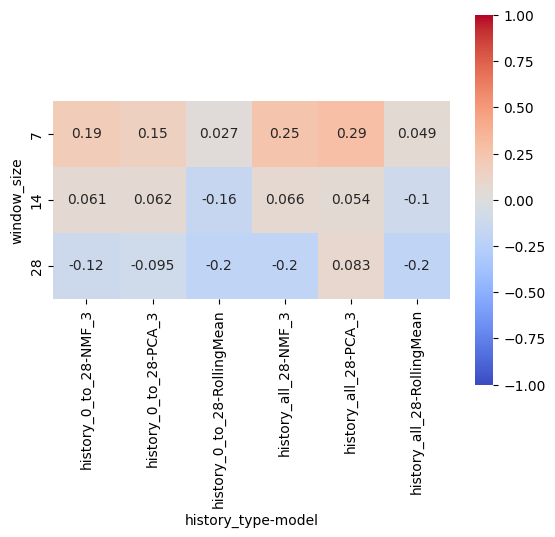

In [180]:
detected_anomalies = data_df.groupby(['subject_id', 'history_type', 'anomaly_freq', 'window_size'])[['anomaly'] + anomaly_detector_cols].sum(numeric_only=False)
split_by = ['history_type', 'window_size']
results = []
for c in anomaly_detector_cols:
    # Get spearman correlation of # detected anomalies per subject/anomaly frequency
    # Separate different data generation types (history_type) and model training window size
    res = detected_anomalies.reset_index().groupby(split_by)[['anomaly', c]].corr(method='spearman').reset_index()
    res = res[res[f'level_{len(split_by)}'] == 'anomaly'][split_by + [c]].rename(columns={c:c.split('_anomaly')[0]}).set_index(split_by)
    results.append(res)

results_df = pd.concat(results, axis=1).reset_index()
sns.heatmap(
    results_df.melt(id_vars=split_by, var_name='model', value_name='spearmanr').pivot_table(
        index='window_size',
        columns=['history_type', 'model'],
        values='spearmanr',
    ),
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    annot=True,
    cmap='coolwarm'
)

In [168]:
from typing import Dict
from numpy.typing import ArrayLike
anomaly_detector_behavior = []
groupby_cols = ['subject_id', 'anomaly_freq'] + split_by
for info, subject_data in tqdm(data_df.groupby(groupby_cols)):
    # day of detected anomaly
    anomaly_days: Dict[str, ArrayLike] = {
        c: subject_data.loc[subject_data[c], 'study_day'].values for c in anomaly_detector_cols
    }

    # Actual induced anomalies
    real_anomaly = subject_data.loc[subject_data['anomaly'], 'study_day'].values
    
    anomaly_distance = {
        c: np.full(real_anomaly.shape, np.nan) for c in anomaly_detector_cols
    }
    # Calculate distance for each induced anomaly to closest future detected anomaly
    for i in range(real_anomaly.shape[0]):
        for c in anomaly_detector_cols:
            distances = anomaly_days[c] - real_anomaly[i] 
            pos_distances = distances[distances >= 0]

            # If no future detected anomaly, fill distance with np.nan
            if np.any(pos_distances):
                min_pos = np.min(pos_distances)
            else:
                min_pos = np.nan
            anomaly_distance[c][i] = min_pos
    anomaly_distance = pd.DataFrame(anomaly_distance)
    for i, c in enumerate(groupby_cols):
        anomaly_distance[c] = info[i]
    anomaly_detector_behavior.append(anomaly_distance)

# for each detector's anomalies, find closest day of real anomaly on or after detected, and calculate distance
# If no real anomaly before detected anomaly, distance = np.nan
# TODO: calculate how many induced anomalies were missed [no detected anomaly before next anomaly]
# TODO: calculate how many detected anomalies were before the first induced
anomaly_detector_behavior = pd.concat(anomaly_detector_behavior)
anomaly_detector_behavior = anomaly_detector_behavior.melt(id_vars=groupby_cols, var_name='model', value_name='distance')
anomaly_detector_behavior

100%|██████████| 900/900 [00:01<00:00, 646.46it/s]


,subject_id,anomaly_freq,history_type,window_size,model,distance
0,SID_0,7,history_0_to_28,7,RollingMean_anomaly,42.0
1,SID_0,7,history_0_to_28,7,RollingMean_anomaly,35.0
2,SID_0,7,history_0_to_28,7,RollingMean_anomaly,28.0
3,SID_0,7,history_0_to_28,7,RollingMean_anomaly,21.0
4,SID_0,7,history_0_to_28,7,RollingMean_anomaly,14.0
...,...,...,...,...,...,...
18895,SID_9,28,history_all_28,14,NMF_3_anomaly,NaN
18896,SID_9,28,history_all_28,14,NMF_3_anomaly,NaN
18897,SID_9,28,history_all_28,28,NMF_3_anomaly,1.0
18898,SID_9,28,history_all_28,28,NMF_3_anomaly,NaN


<AxesSubplot: xlabel='window_size-anomaly_freq', ylabel='history_type-model'>

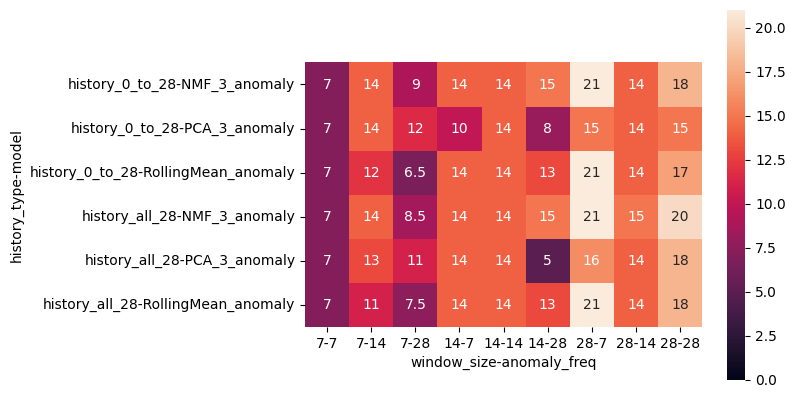

In [179]:
sns.heatmap(
    anomaly_detector_behavior.pivot_table(
        values='distance',
        columns=['window_size', 'anomaly_freq'],
        index=['history_type', 'model'],
        aggfunc='median',
    ),
    annot=True,
    square=True,
    vmin=0,
)

In [172]:
anomaly_detector_behavior.groupby(split_by + ['anomaly_freq', 'model']).distance.describe()

count  \
history_type    window_size anomaly_freq model                        
history_0_to_28 7           7            NMF_3_anomaly        453.0   
                                         PCA_3_anomaly        431.0   
                                         RollingMean_anomaly  470.0   
                            14           NMF_3_anomaly        235.0   
                                         PCA_3_anomaly        207.0   
                                         RollingMean_anomaly  212.0   
                            28           NMF_3_anomaly         92.0   
                                         PCA_3_anomaly         90.0   
                                         RollingMean_anomaly   88.0   
                14          7            NMF_3_anomaly        450.0   
                                         PCA_3_anomaly        485.0   
                                         RollingMean_anomaly  429.0   
                            14           NMF_3_anomaly        218.0   
                                         PCA_3_anomaly        233.0   
                                         RollingMean_anomaly  213.0   
                            28           NMF_3_anomaly         91.0   
                                         PCA_3_anomaly         99.0   
                                         RollingMean_anomaly   97.0   
                28          7            NMF_3_anomaly        443.0   
                                         PCA_3_anomaly        442.0   
                                         RollingMean_anomaly  420.0   
                            14           NMF_3_anomaly        208.0   
                                         PCA_3_anomaly        211.0   
                                         RollingMean_anomaly  210.0   
                            28           NMF_3_anomaly         94.0   
                                         PCA_3_anomaly        105.0   
                                         RollingMean_anomaly   96.0   
history_all_28  7           7            NMF_3_anomaly        472.0   
                                         PCA_3_anomaly        454.0   
                                         RollingMean_anomaly  475.0   
                            14           NMF_3_anomaly        233.0   
                                         PCA_3_anomaly        205.0   
                                         RollingMean_anomaly  215.0   
                            28           NMF_3_anomaly         94.0   
                                         PCA_3_anomaly         90.0   
                                         RollingMean_anomaly   84.0   
                14          7            NMF_3_anomaly        432.0   
                                         PCA_3_anomaly        451.0   
                                         RollingMean_anomaly  425.0   
                            14           NMF_3_anomaly        225.0   
                                         PCA_3_anomaly        220.0   
                                         RollingMean_anomaly  219.0   
                            28           NMF_3_anomaly         96.0   
                                         PCA_3_anomaly         93.0   
                                         RollingMean_anomaly   95.0   
                28          7            NMF_3_anomaly        413.0   
                                         PCA_3_anomaly        429.0   
                                         RollingMean_anomaly  435.0   
                            14           NMF_3_anomaly        204.0   
                                         PCA_3_anomaly        211.0   
                                         RollingMean_anomaly  197.0   
                            28           NMF_3_anomaly         94.0   
                                         PCA_3_anomaly        103.0   
                                         RollingMean_anomaly   94.0   

                                                                   mean  \
history_ty

<AxesSubplot: xlabel='model', ylabel='distance'>

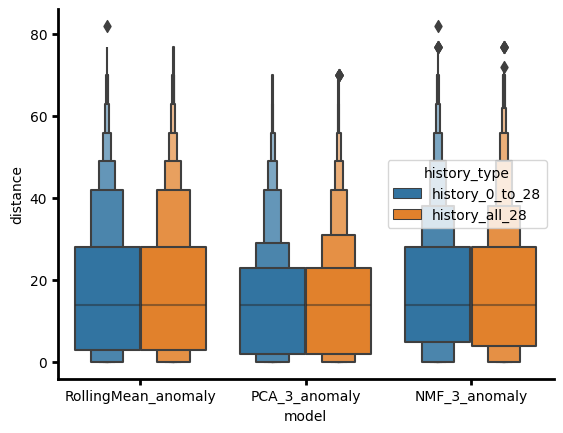

In [169]:

ax = sns.boxenplot(data=anomaly_detector_behavior, x='model', y='distance', hue='history_type')
fa.despine_thicken_axes(ax, fontsize=10)

['RollingMean', '']

In [217]:
models = [c.split('_anomaly')[0] for c in anomaly_detector_cols]
groupby_cols = ['subject_id', 'history_type', 'window_size', 'anomaly_freq']
performance_dict = {
    c: [] for c in groupby_cols 
}
performance_dict['model'] = []
performance_dict['true_positives'] = []
performance_dict['true_negatives'] = []
performance_dict['false_positives'] = []
performance_dict['false_negatives'] = []

for info, subject_data in tqdm(data_df.groupby(groupby_cols)):
    for model in models:
        for i, val in enumerate(info):
            performance_dict[groupby_cols[i]].append(val)
        performance_dict['model'].append(model)
        performance_dict['true_positives'].append((subject_data['anomaly'] & subject_data[model+'_anomaly']).sum())
        performance_dict['true_negatives'].append((~subject_data['anomaly'] & ~subject_data[model+'_anomaly']).sum())
        performance_dict['false_negatives'].append((subject_data['anomaly'] & ~subject_data[model+'_anomaly']).sum())
        performance_dict['false_positives'].append((~subject_data['anomaly'] & subject_data[model+'_anomaly']).sum())

performance_df = pd.DataFrame(performance_dict)
performance_df['sensitivity'] = performance_df['true_positives'] / (performance_df['true_positives'] + performance_df['false_negatives'])
performance_df['specificity'] = performance_df['true_negatives'] / (performance_df['true_negatives'] + performance_df['false_positives']) 
performance_df['accuracy'] = performance_df[['true_positives', 'true_negatives']].sum(axis=1) \
    / performance_df[['true_positives', 'true_negatives', 'false_positives', 'false_negatives']].sum(axis=1)
performance_df

100%|██████████| 900/900 [00:01<00:00, 602.33it/s]


,subject_id,history_type,window_size,anomaly_freq,model,true_positives,true_negatives,false_positives,false_negatives,sensitivity,specificity,accuracy
0,SID_0,history_0_to_28,7,7,RollingMean,3,78,1,12,0.200000,0.987342,0.861702
1,SID_0,history_0_to_28,7,7,PCA_3,3,78,0,12,0.200000,1.000000,0.870968
2,SID_0,history_0_to_28,7,7,NMF_3,2,78,2,12,0.142857,0.975000,0.851064
3,SID_0,history_0_to_28,7,14,RollingMean,3,84,1,6,0.333333,0.988235,0.925532
4,SID_0,history_0_to_28,7,14,PCA_3,1,84,3,6,0.142857,0.965517,0.904255
...,...,...,...,...,...,...,...,...,...,...,...,...
2695,SID_9,history_all_28,28,14,PCA_3,1,84,1,6,0.142857,0.988235,0.923913
2696,SID_9,history_all_28,28,14,NMF_3,0,84,2,6,0.000000,0.976744,0.913043
2697,SID_9,history_all_28,28,28,RollingMean,1,87,2,3,0.250000,0.977528,0.946237
2698,SID_9,history_all_28,28,28,PCA_3,1,87,1,3,0.250000,0.988636,0.956522


Text(0.5, 1.0, 'accuracy')

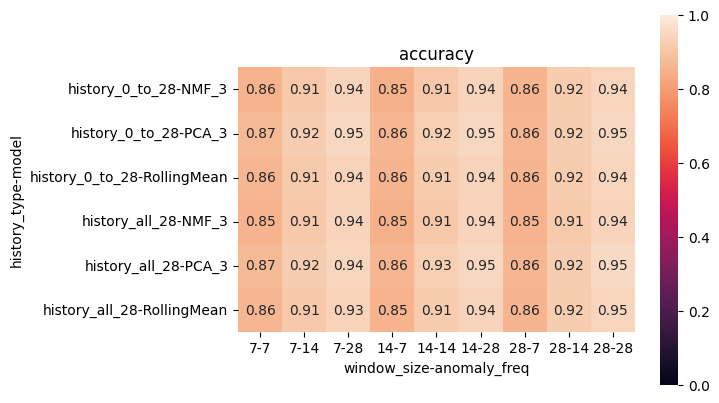

In [219]:
ax = sns.heatmap(
    performance_df.pivot_table(
        values='accuracy',
        columns=['window_size', 'anomaly_freq'],
        index=['history_type', 'model'],
    ),
    annot=True,
    square=True,
    vmin=0,
    vmax=1,
)
ax.set_title('accuracy')


Text(0.5, 1.0, 'sensitivity')

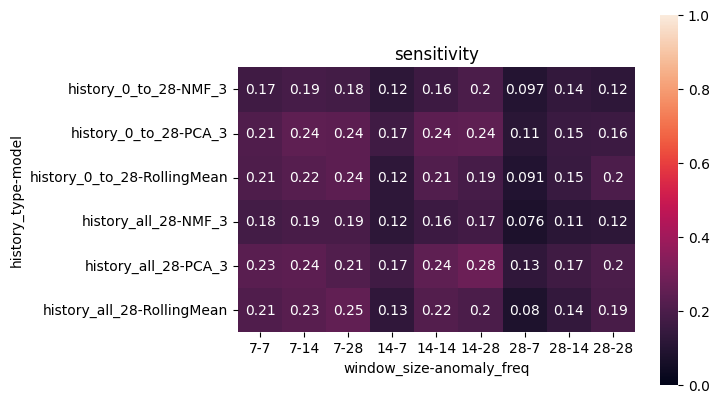

In [220]:

ax = sns.heatmap(
    performance_df.pivot_table(
        values='sensitivity',
        columns=['window_size', 'anomaly_freq'],
        index=['history_type', 'model'],
    ),
    annot=True,
    square=True,
    vmin=0,
    vmax=1,
)
ax.set_title('sensitivity')


Text(0.5, 1.0, 'specificity')

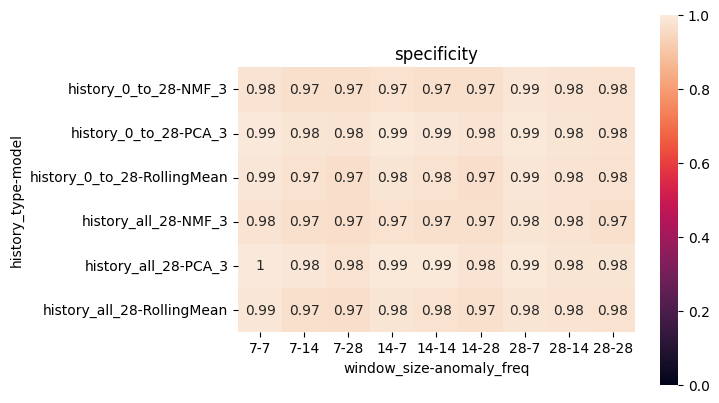

In [221]:

ax = sns.heatmap(
    performance_df.pivot_table(
        values='specificity',
        columns=['window_size', 'anomaly_freq'],
        index=['history_type', 'model'],
    ),
    annot=True,
    square=True,
    vmin=0,
    vmax=1,
)
ax.set_title('specificity')